# Gaussian Process on the Toy dataset, using Inducing Points

# Github

In [ ]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Project18/GPs


# Imports

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 21.8 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/datasets


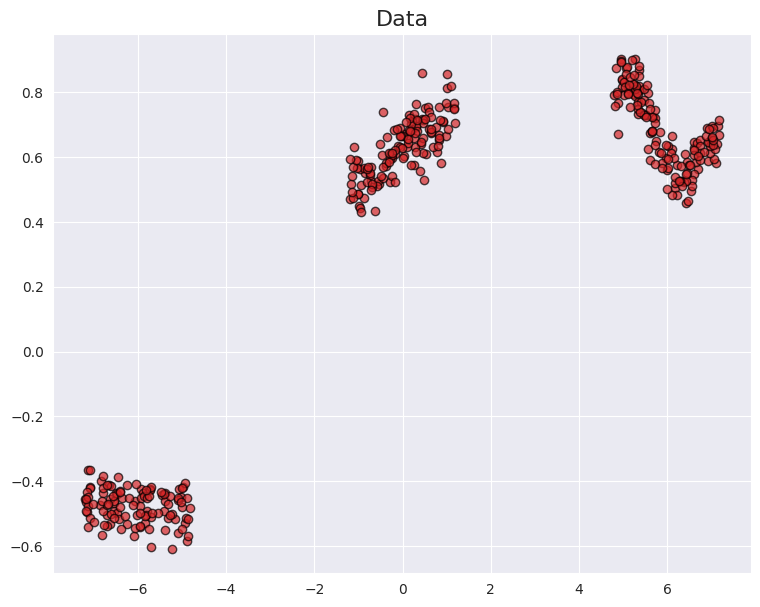

Everything up-to-date


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/toy.ipynb # Run the toy notebook which is in the datasets folder(toy dataset)


# Training data from toy.ipynb

In [ ]:
xTrain, yTrain = x, y # x, y are defined in ../datasets/toy.ipynb
xTrain, yTrain = torch.from_numpy(xTrain), torch.from_numpy(yTrain) # Convert them to tensors
print(len(xTrain))

400


# Inducing Points

In [ ]:
amount_of_points = 30
inducingPointsX = xTrain[:amount_of_points] # Choose how many points to pick
inducingPointsY = yTrain[:amount_of_points] # Choose how many points to pick
print(len(inducingPointsX))

30


# The GP model

In [ ]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x_Inducing, y_Inducing, likelihood):
        super(GPModel, self).__init__(x_Inducing, y_Inducing, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [ ]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Training Function

In [ ]:
import os
def train(model, xTrain, yTrain): # Train the model on training data: xTrain, yTrain

  smoke_test = ('CI' in os.environ)
  training_iter = 2 if smoke_test else 250


  # Find optimal model hyperparameters
  model.train()
  model.likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  # Train without printing to ensure the training method is as fast as possible
  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(xTrain)
      # Calc loss and backprop gradients
      loss = -mll(output, yTrain)
      loss.backward()
      optimizer.step()


# Train the Model#

In [ ]:
%time train(model, inducingPointsX, inducingPointsY)

CPU times: user 904 ms, sys: 7.86 ms, total: 912 ms
Wall time: 925 ms


# Test data

In [ ]:
# Observing the plot of the toy dataset, x varies between -7-7
xTest = torch.linspace(-9, 9, 50)

# The posterior mean, variance and Covariance Matrix

In [ ]:
model.eval() # eval mode is for computing predictions through the model posterior
f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
f_mean = f_preds.mean # Predictive mean
f_var = f_preds.variance # Predictive variance
f_covar = f_preds.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean.size())
print()
print("Variance Dimension: ", f_var.size())
print()
print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


# Plots of samples from the GP

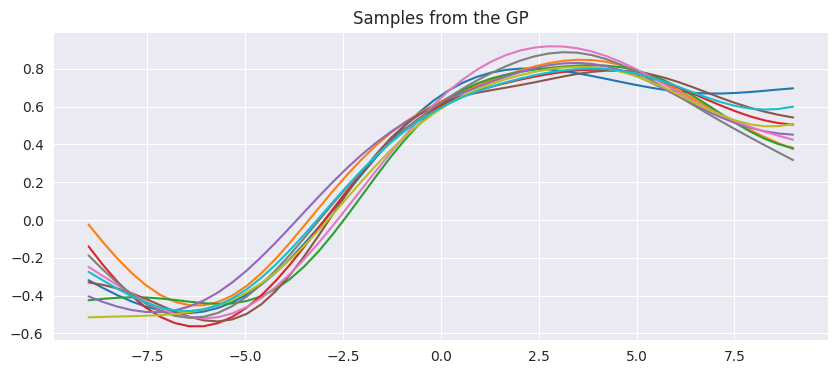

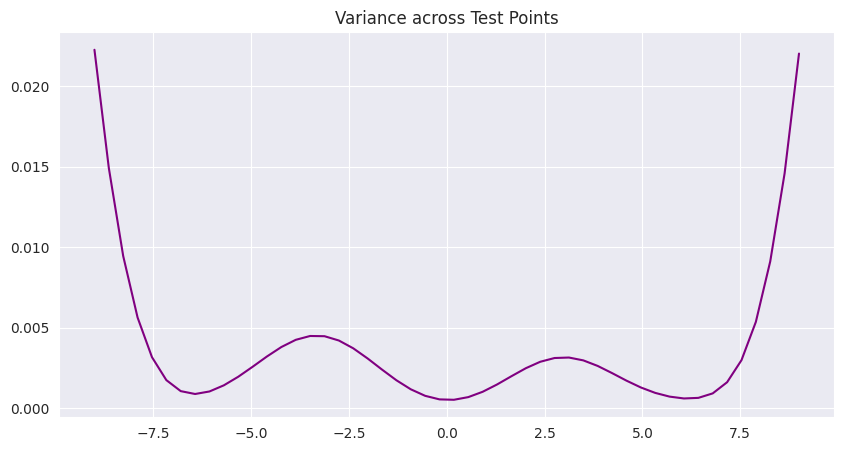

In [ ]:
# Convert to numpy
xTestPlot = xTest.detach().numpy()
f_meanPlot = f_mean.detach().numpy()
f_varPlot = f_var.detach().numpy()
# Plot samples from the GP
plt.figure(figsize=(10, 4))
for i in range(10):  # Generate 20 samples
    f_sample = f_preds.sample().detach().numpy()
    plt.plot(xTestPlot, f_sample)
plt.title('Samples from the GP')
plt.show()
# Plot variance
plt.figure(figsize=(10, 5))
plt.plot(xTestPlot, f_varPlot, 'purple')
plt.title('Variance across Test Points')
plt.show()

# Predictive Distribution

In [ ]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Plot with RBF kernel

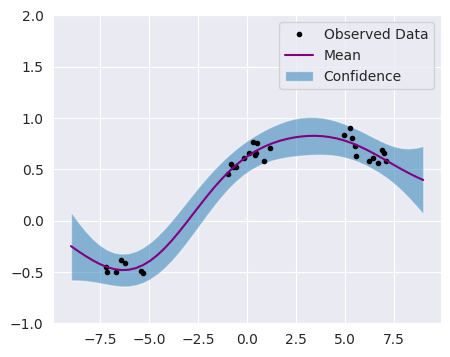

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(5, 4))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(inducingPointsX.numpy(), inducingPointsY.numpy(), 'k.')
    # Plot predictive means as purple line
    ax.plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Compare different amount of points


Inducing Points:  5
CPU times: user 1.11 s, sys: 10.8 ms, total: 1.12 s
Wall time: 1.16 s

Inducing Points:  10


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 1e+03 ms, sys: 9.94 ms, total: 1.01 s
Wall time: 1.04 s

Inducing Points:  50
CPU times: user 820 ms, sys: 2.32 ms, total: 823 ms
Wall time: 826 ms

Inducing Points:  100
CPU times: user 963 ms, sys: 6.08 ms, total: 969 ms
Wall time: 970 ms

Inducing Points:  200
CPU times: user 1.67 s, sys: 10.4 ms, total: 1.68 s
Wall time: 1.68 s

Inducing Points:  400
CPU times: user 5.95 s, sys: 0 ns, total: 5.95 s
Wall time: 7.1 s


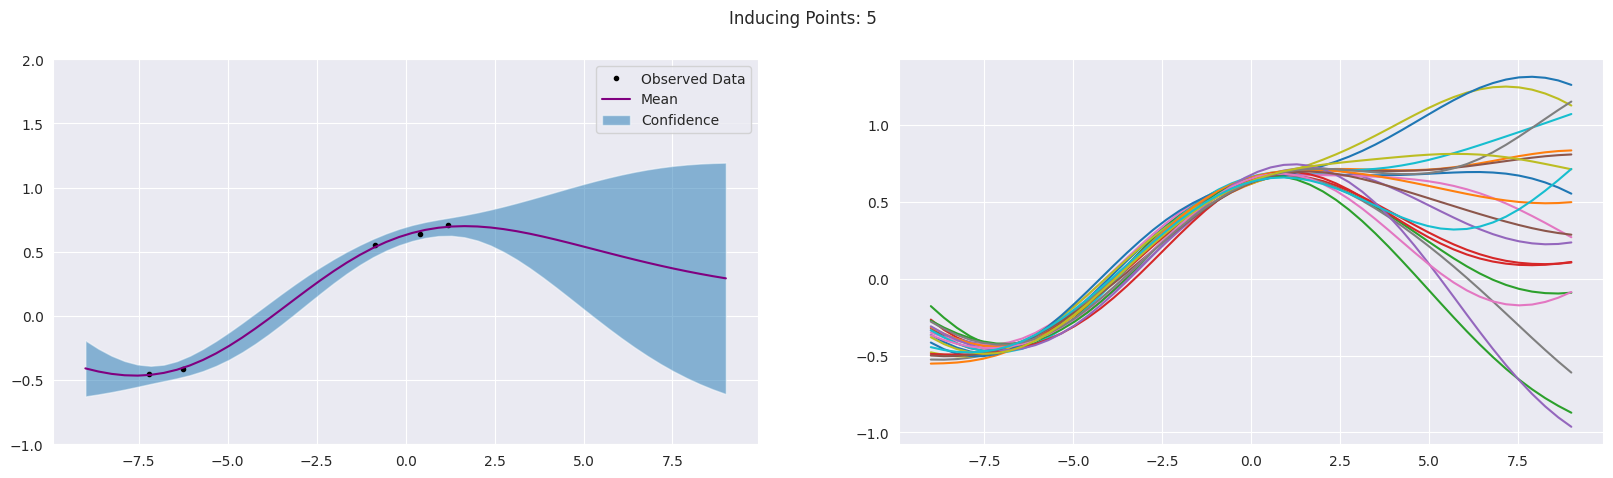

<Figure size 1000x400 with 0 Axes>

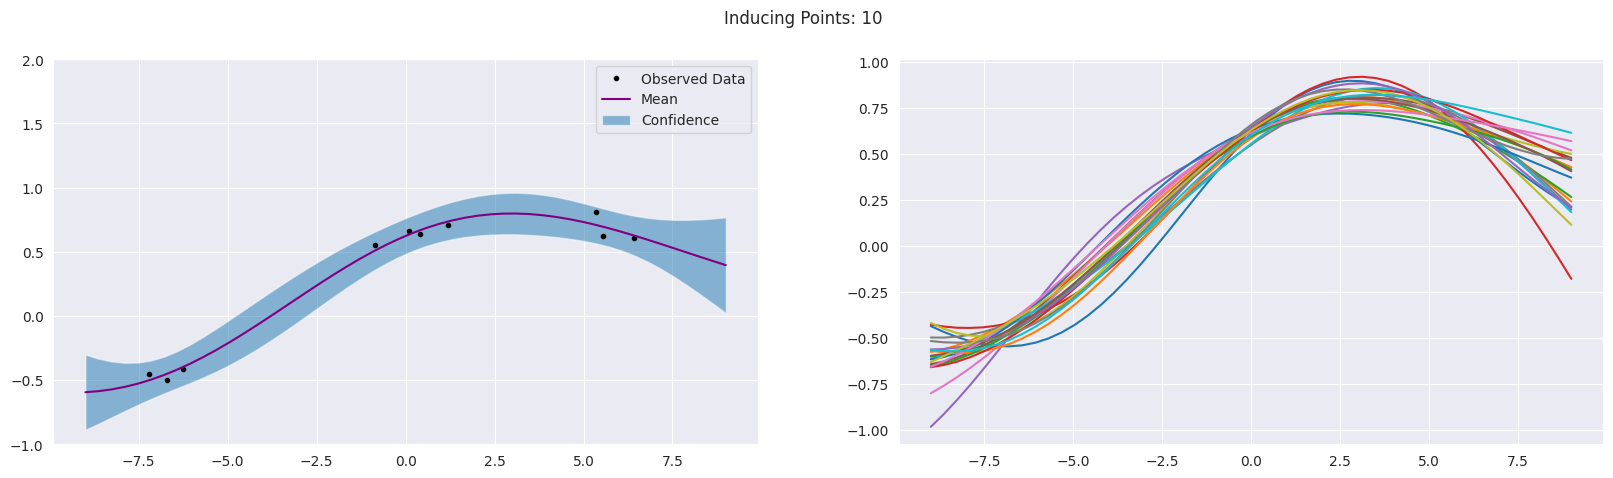

<Figure size 1000x400 with 0 Axes>

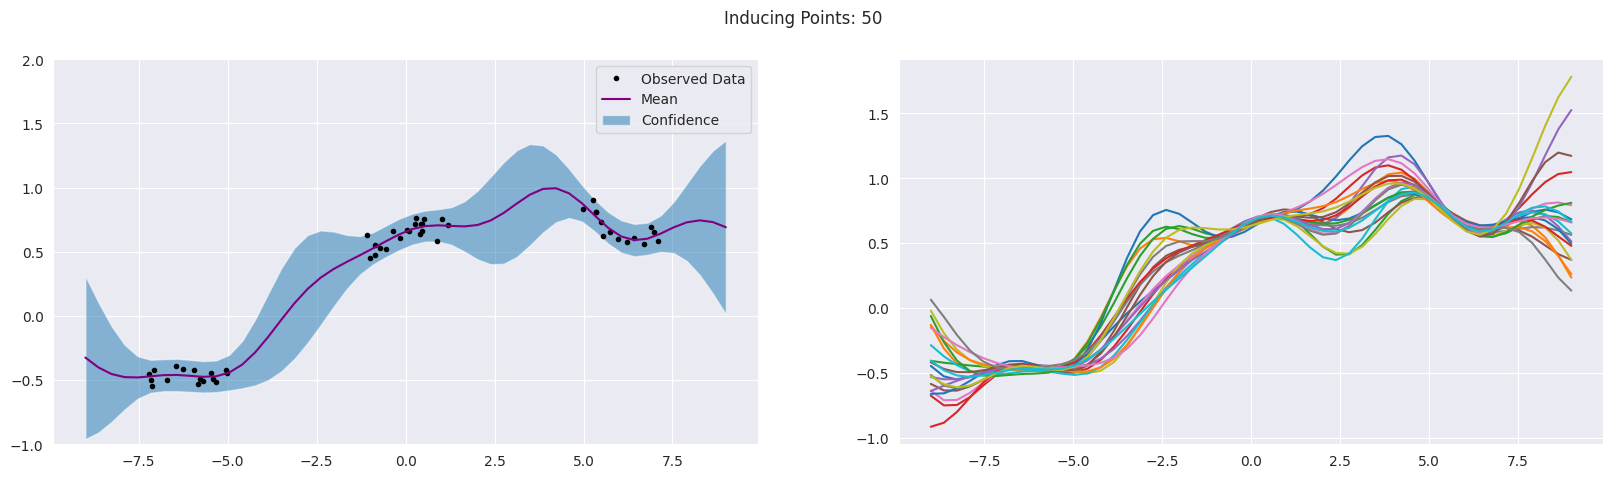

<Figure size 1000x400 with 0 Axes>

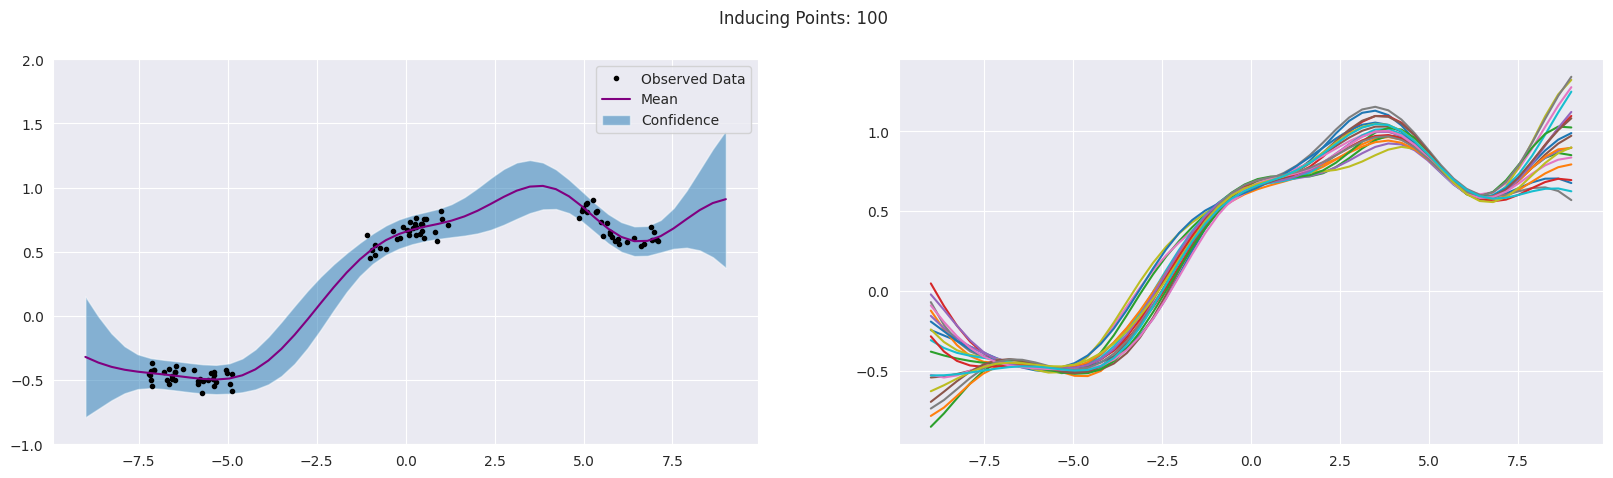

<Figure size 1000x400 with 0 Axes>

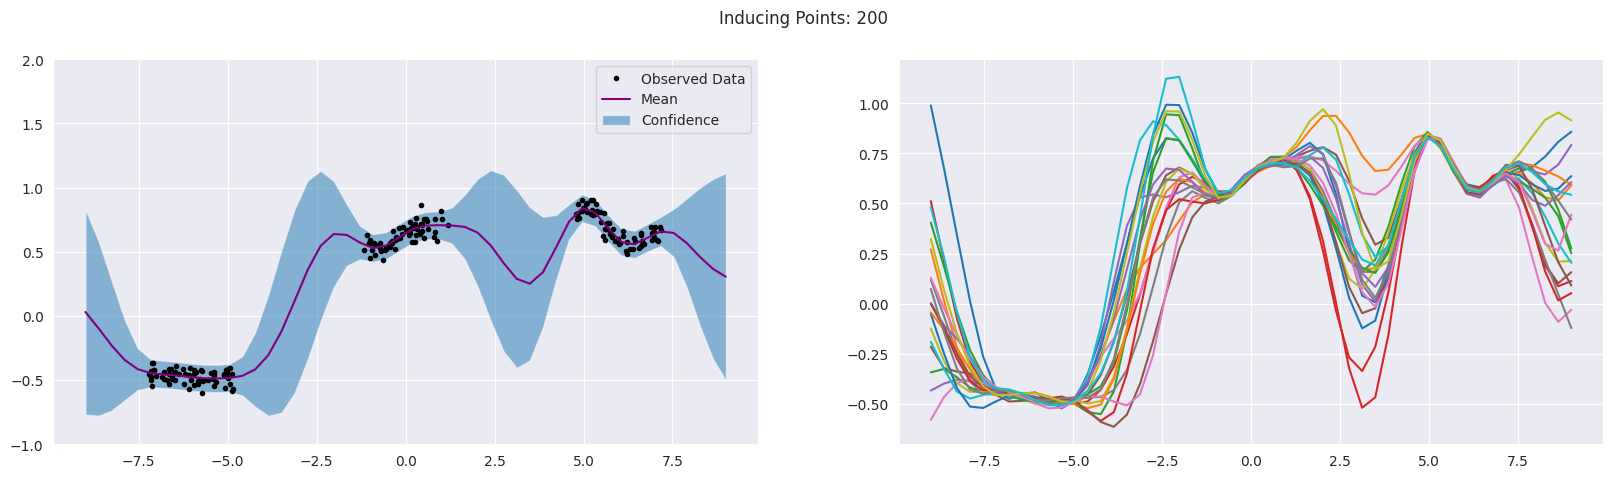

<Figure size 1000x400 with 0 Axes>

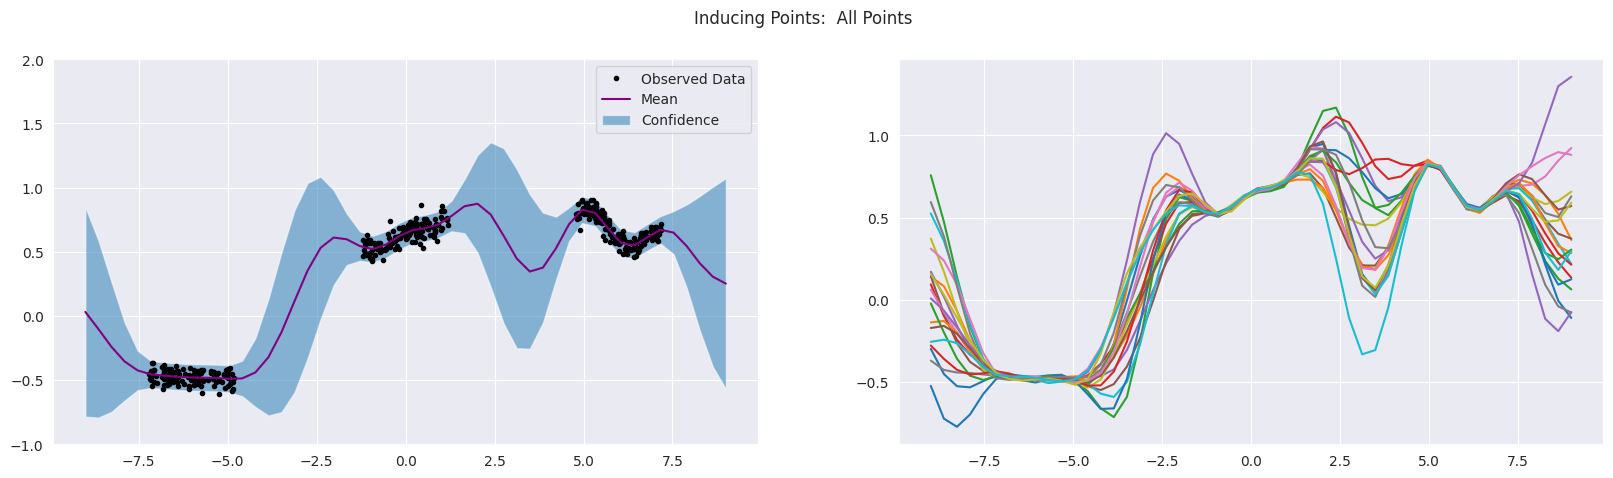

<Figure size 1000x400 with 0 Axes>

In [77]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPoints(listOfPoints, rows, columns):
  maxPoints = len(xTrain) # The max amount of points in training points
  for points in listOfPoints:
    inducingPointsX = xTrain[:points] # Choose how many points to pick
    inducingPointsY = yTrain[:points] # Choose how many points to pick

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    print()
    print("Inducing Points: ", points)

    %time train(model, inducingPointsX, inducingPointsY) # Train the model
    # Plot
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()



    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
        observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

        f, ax = plt.subplots(1, 2, figsize=(20, 5))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black dots
        ax[0].plot(inducingPointsX.numpy(), inducingPointsY.numpy(), 'k.')
        # Plot predictive means as purple line
        ax[0].plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
        # Shade between the lower and upper confidence bounds
        ax[0].fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax[0].set_ylim([-1, 2])
        ax[0].legend(['Observed Data', 'Mean', 'Confidence'])

        f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
        f_mean = f_preds.mean # Predictive mean
        f_var = f_preds.variance # Predictive variance
        xTestPlot = xTest.detach().numpy()
        f_meanPlot = f_mean.detach().numpy()
        f_varPlot = f_var.detach().numpy()
        # Plot samples from the GP
        plt.figure(figsize=(10, 4))
        for i in range(20):  # Generate 20 samples
            f_sample = f_preds.sample().detach().numpy()
            ax[1].plot(xTestPlot, f_sample)
        if(points == maxPoints):

           f.suptitle('Inducing Points:  All Points')  # If all training points are used
        else:
          f.suptitle('Inducing Points: '+ str(points)) # Else print current amount of points

severalInducingPoints([5,10,50,100,200,400], 2, 3)


In [ ]:
!git push

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.03 MiB | 9.44 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Sabelz/Project18.git
   48c175b..6700990  main -> main
